In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)

In [2]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import tensorflow as tf
import torch

import emcee
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

2024-03-15 11:53:55.036253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_threads = 24
tf.config.threading.set_inter_op_parallelism_threads(n_threads)
tf.config.threading.set_intra_op_parallelism_threads(n_threads)
# note: does NOT work to call sbi_tools.set_N_threads for some reason, need to do it here
torch.set_num_threads(n_threads)

In [4]:
run_moment = True
run_sbi = False
run_emcee = True
run_dynesty = False

In [5]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

tag_fit = '_emuPk'

In [6]:

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
print(f"Using {n_threads} threads")

48 CPUs
Using 24 threads


In [7]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Load data

In [8]:
tag_emuPk = '_2param'
tag_errG = f'_boxsize500'
#tag_errG = f''
n_tot = 2000

fn_emuPk = f'../data/emuPks/emuPks{tag_emuPk}.npy'
fn_emuPk_params = f'../data/emuPks/emuPks_params{tag_emuPk}.txt'
fn_emuk = f'../data/emuPks/emuPks_k{tag_emuPk}.txt'
fn_emuPkerrG = f'../data/emuPks/emuPks_errgaussian{tag_emuPk}{tag_errG}.npy'

Pk_noiseless = np.load(fn_emuPk)
gaussian_error_pk = np.load(fn_emuPkerrG)
theta = np.genfromtxt(fn_emuPk_params, delimiter=',', names=True)
param_names = theta.dtype.names
# from tuples to 2d array
theta = np.array([list(tup) for tup in theta])

kk = np.genfromtxt(fn_emuk)

In [9]:
rng = np.random.default_rng(42)
idx_select = rng.choice(np.arange(Pk_noiseless.shape[0]), n_tot, replace=False)
Pk_noiseless = Pk_noiseless[idx_select]
gaussian_error_pk = gaussian_error_pk[idx_select]
theta = theta[idx_select]


In [10]:
n_tot = theta.shape[0]
n_params = theta.shape[1]

In [11]:
param_label_dict = {'omega_cold': r'$\Omega_\mathrm{m}$',
                'sigma8_cold': r'$\sigma_{8}$',
                'sigma_8': r'$\sigma_{8}$',
                'hubble': r'$h$',
                'h': r'$h$',
                'ns': r'$n_\mathrm{s}$',
                'n_s': r'$n_\mathrm{s}$',
                'omega_baryon': r'$\Omega_\mathrm{b}$',}
param_labels = [param_label_dict[param_name] for param_name in param_names]

In [12]:
print(Pk_noiseless.shape, theta.shape, gaussian_error_pk.shape)

(2000, 30) (2000, 2) (2000, 30)


Add some error!

In [13]:
rng = np.random.default_rng(42)
Pk = rng.normal(Pk_noiseless, gaussian_error_pk)
print(Pk.shape)

(2000, 30)


Plot P(k) data:

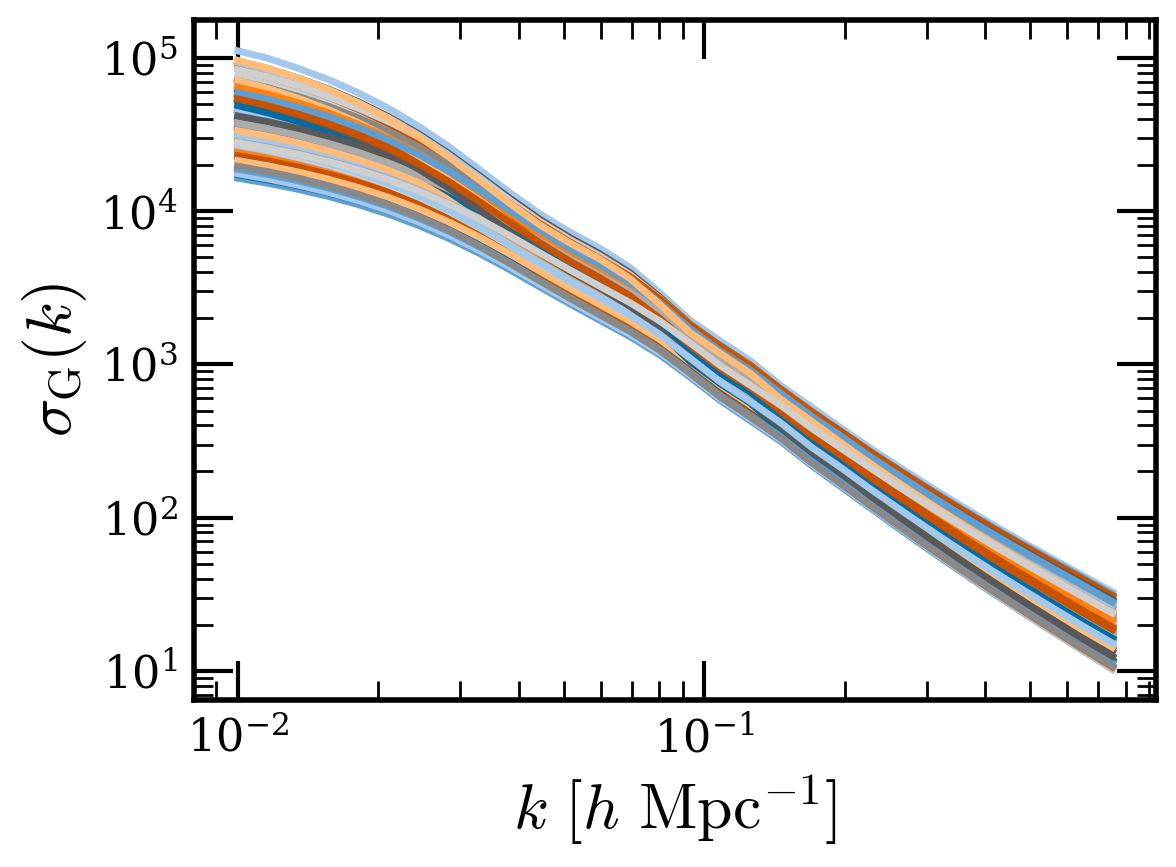

In [14]:
n_plot = 100
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_plot):
    ax.loglog(kk, gaussian_error_pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$\sigma_\text{G}(k)$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

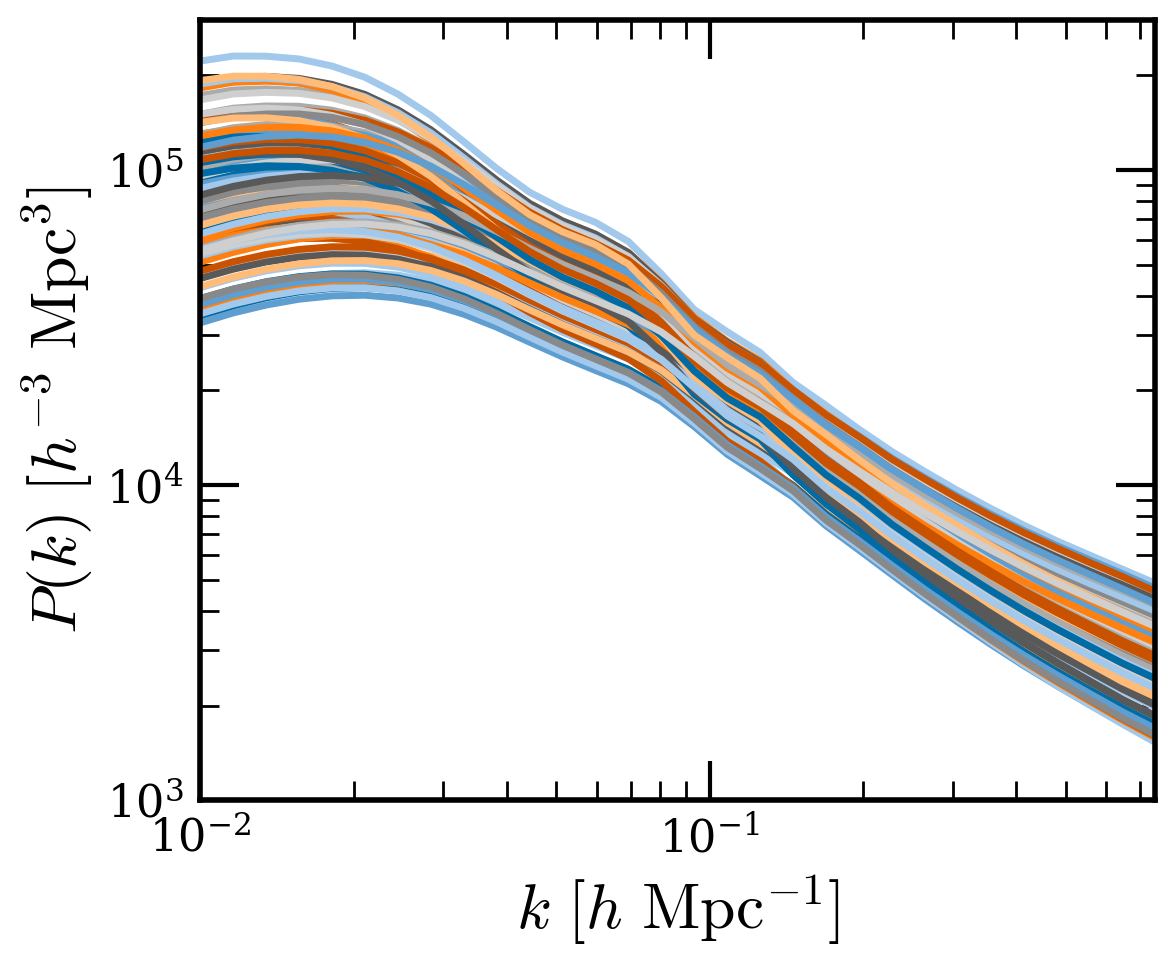

In [15]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 5))
for iLH in range(n_plot):
    ax.loglog(kk, Pk_noiseless[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

ax.set_xlim(1e-2, 0.75)
ax.set_ylim(1e3, 3e5)
mpl.pyplot.tight_layout()
mpl.pyplot.show()

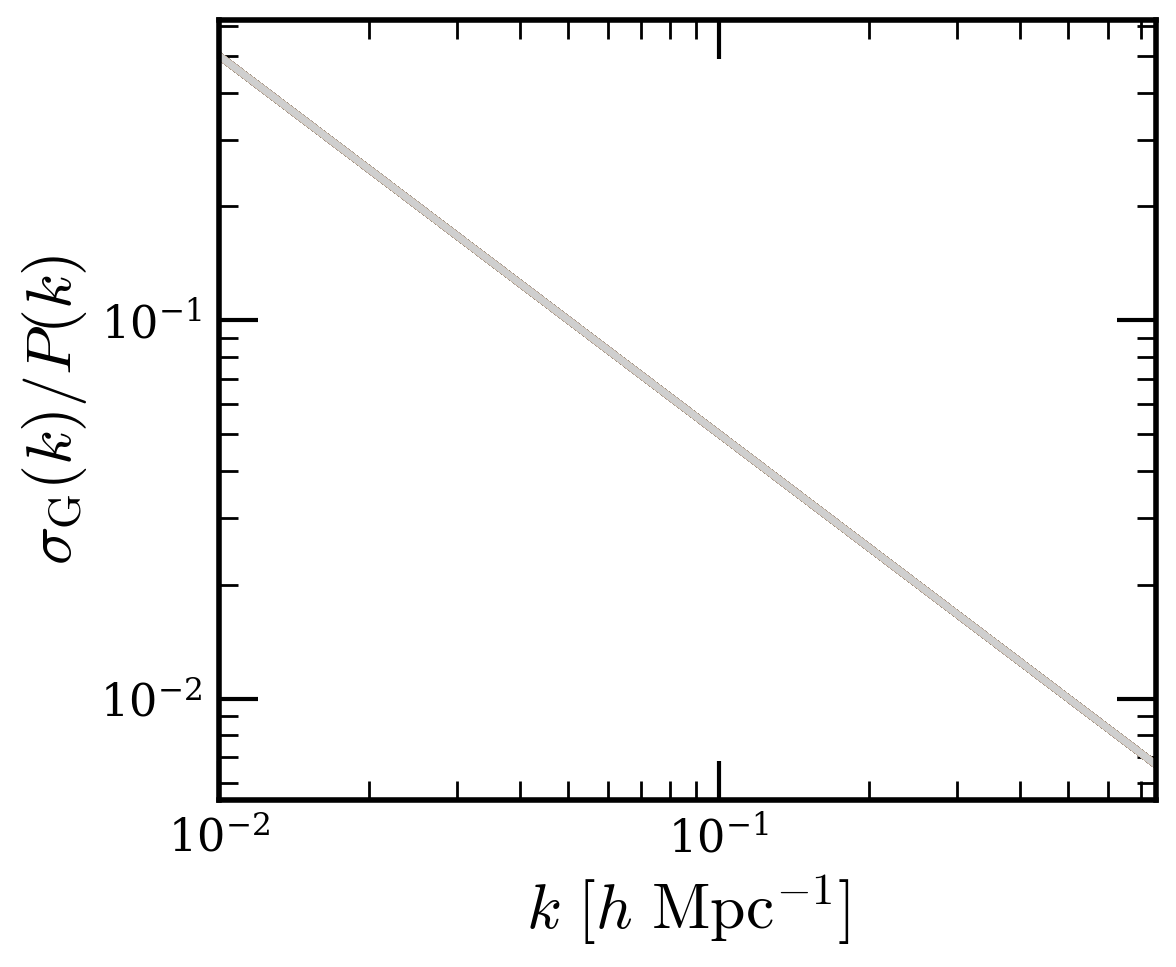

In [16]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 5))
for iLH in range(n_plot):
    ax.loglog(kk, gaussian_error_pk[iLH]/Pk_noiseless[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$\sigma_\text{G}(k)/P(k)$', fontsize=23)

ax.set_xlim(1e-2, 0.75)
#ax.set_ylim(1e3, 3e5)
mpl.pyplot.tight_layout()
mpl.pyplot.show()

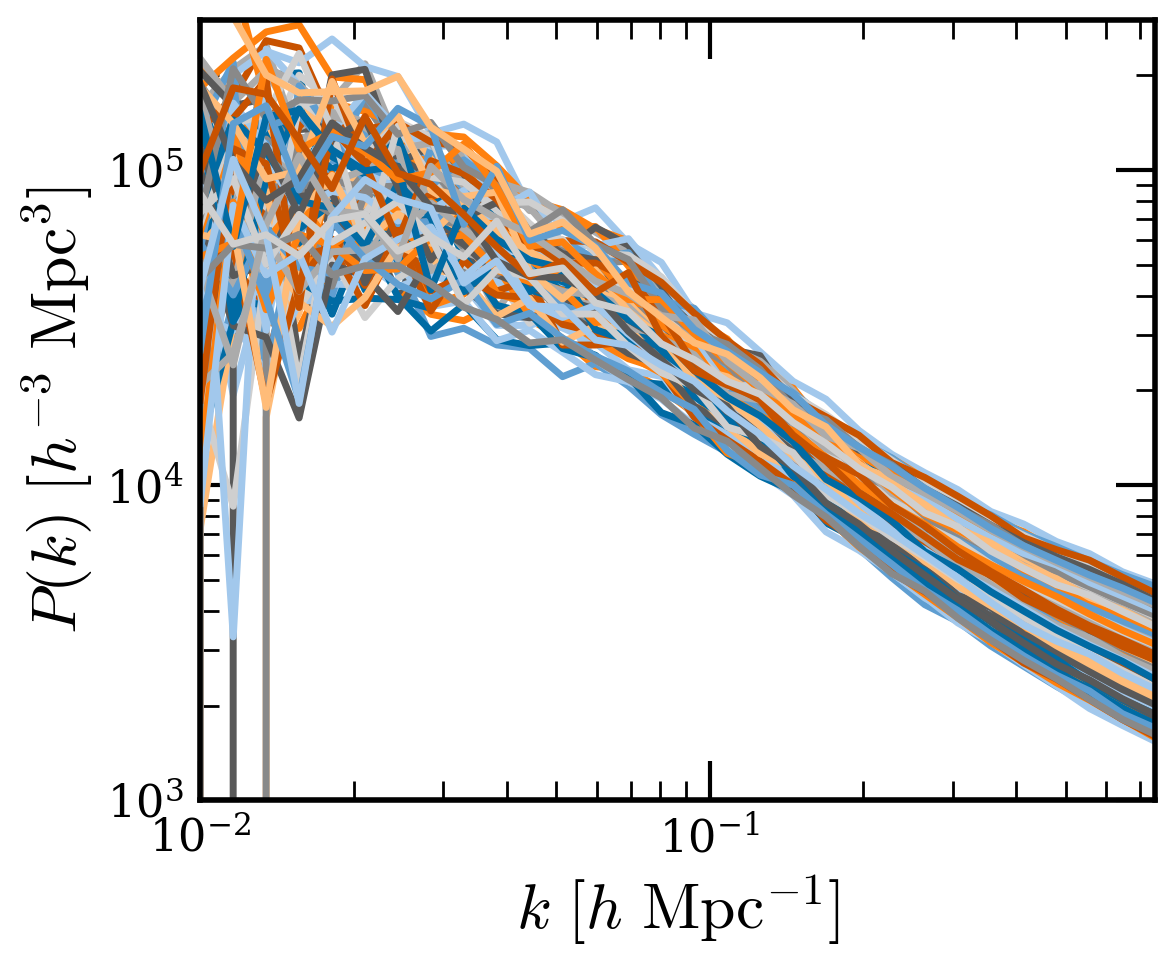

In [17]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 5))
for iLH in range(n_plot):
    ax.loglog(kk, Pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

ax.set_xlim(1e-2, 0.75)
ax.set_ylim(1e3, 3e5)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

Text(0, 0.5, '$\\sigma_{8}$')

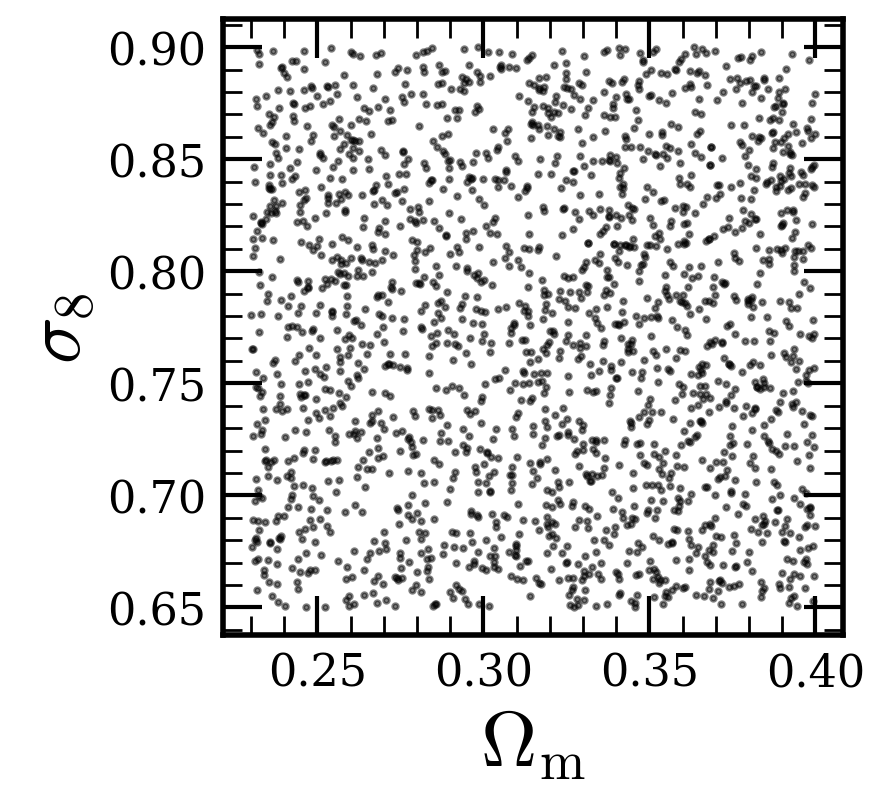

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(theta[:, 0], theta[:, 1], c='k', s=4, alpha=0.5)
plt.xlabel(param_labels[0])
plt.ylabel(param_labels[1])


In [19]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 2


Split into train-val-test

In [20]:
#p_train, p_test = 0.2, 0.75
p_train, p_test = 0.4, 0.5
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

(800, 2) (200, 2) (1000, 2)


In [21]:
Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

Pk_noiseless_train = Pk_noiseless[:train_split]
Pk_noiseless_val = Pk_noiseless[train_split:test_split]
Pk_noiseless_test = Pk_noiseless[test_split:]

# should really do this mask just on training set, but for now have some bad test data for some reason
mask = np.all(Pk>0, axis=0)
Pk_train = Pk_train[:,mask]
Pk_val = Pk_val[:,mask]
Pk_test = Pk_test[:,mask]
Pk_noiseless_train = Pk_noiseless_train[:,mask]
Pk_noiseless_val = Pk_noiseless_val[:,mask]
Pk_noiseless_test = Pk_noiseless_test[:,mask]
k = kk[mask]

gaussian_error_pk_train = gaussian_error_pk[:train_split][:,mask]
gaussian_error_pk_val = gaussian_error_pk[train_split:test_split][:,mask]
gaussian_error_pk_test = gaussian_error_pk[test_split:][:,mask]

In [22]:
n_dim = Pk_train.shape[1]
print(n_tot, n_params, n_dim)

2000 2 26


Set up test model now so we can viz

In [23]:
# fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
# fontsize = 24
# fontsize1 = 18

# alpha = 0.7

# tmp_Pk_plot = Pk_train
# tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
# ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5, label='training set')

# tmp_Pk_plot = Pk_test
# tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
# ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5, label='test set')
    
# ax.plot(np.log10(k), np.log10(Pk_test[idx_test]), c='m', alpha=alpha, lw=2, label='test data')
    
# ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
# ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

# mpl.pyplot.tight_layout()
# mpl.pyplot.show()

In [24]:
class Scaler:

    def __init__(self, func='log_minmax'):
        self.func = func
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train, axis=0)
        self.x_train_max = np.max(x_train, axis=0)

    def scale(self, x):
        if self.func=='log_minmax':
            return self.scale_log_minmax(x)
        elif self.func=='minmax':
            return self.scale_minmax(x)
        else:
            raise ValueError(f"Function {self.func} not recognized")

    def unscale(self, x):
        if self.func=='log_minmax':
            return self.unscale_log_minmax(x)
        elif self.func=='minmax':
            return self.unscale_minmax(x)
        else:
            raise ValueError(f"Function {self.func} not recognized")
       
    def scale_error(self, err, x):
        if self.func=='log_minmax':
            return self.scale_error_log_minmax(err, x)
        elif self.func=='minmax':
            raise ValueError(f"Error not implemented for {self.func}")
        else:
            raise ValueError(f"Function {self.func} not recognized")

    def scale_log_minmax(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.    x_train_min))
        return log_x_norm
    
    def unscale_log_minmax(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  
        
    def scale_error_log_minmax(self, err, x):
        # need 1/np.log(10) factor bc working in base 10
        dydx = 1./x * 1/np.log(10) * 1./(np.log10(self.x_train_max) - np.log10(self.x_train_min))
        err_scaled = np.sqrt(np.multiply(dydx**2, err**2))
        return err_scaled
    
    def scale_log(self, x):
        return np.log10(x)
    
    def scale_log_error(self, err, x):
        return (1./x) * (1/np.log(10)) * err
    
    def scale_minmax(self, x):
        return (x - self.x_train_min) / (self.x_train_max - self.x_train_min)
    
    def unscale_minmax(self, x_scaled):
        return x_scaled * (self.x_train_max - self.x_train_min) + self.x_train_min

    

ok gaussian error is not the same here...! check how bacco is measuring

In [25]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

gaussian_error_pk_train_scaled = scaler.scale_error(gaussian_error_pk_train, Pk_train)
gaussian_error_pk_val_scaled = scaler.scale_error(gaussian_error_pk_val, Pk_val)
gaussian_error_pk_test_scaled = scaler.scale_error(gaussian_error_pk_test, Pk_test)

In [26]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

1465.6186307258347 308341.6911805022
0.0 1.0
1426.1180251467015 313752.53224241827
-0.37297512056326837 1.057191116378047


In [27]:
print(Pk_train.shape, theta_train.shape, gaussian_error_pk_train.shape, n_params)

(800, 26) (800, 2) (800, 26) 2


### Set up emulator, visualize

In [28]:
emu_param_names = param_names
#emu = baccoemu.Lbias_expansion(verbose=False)
fn_emu = '/dipc_storage/cosmosims/data_share/lbias_emulator/lbias_emulator2.0.0'
emu = baccoemu.Lbias_expansion(verbose=False, 
                               nonlinear_emu_path=fn_emu,
                               nonlinear_emu_details='details.pickle',
                               nonlinear_emu_field_name='NN_n',
                               nonlinear_emu_read_rotation=False)
#cosmo_params = setup_cosmo_emu()
cosmo_params = genP.setup_cosmo_emu()
# TODO save and read bias params
bias_params = [1., 0., 0., 0.]

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using vers

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using 

Nonlinear l-bias emulator loaded in memory.
HIIII
Setting up emulator cosmology


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
# dict_bounds = {}
# for pp, param_name in enumerate(param_names):
#     dict_bounds[param_name] = [np.min(theta[:,pp]), np.max(theta[:,pp])]
param_keys = emu.emulator['nonlinear']['keys']
emu_bounds =  emu.emulator['nonlinear']['bounds']
dict_bounds = {name: emu_bounds[param_keys.index(name)] for name in param_names}

In [30]:
# def setup_cosmo_emu():
#     print("Setting up emulator cosmology")
#     cosmo_params = {
#         #'omega_cold'    :  Om,
#         #'sigma8_cold'   :  sigma8, # if A_s is not specified
#         'omega_baryon'  :  param_dict_fixed['omega_baryon'],
#         'ns'            :  param_dict_fixed['n_s'],
#         #'hubble'        :  hubble,
#         'neutrino_mass' :  0.0,
#         'w0'            : -1.0,
#         'wa'            :  0.0,
#         'expfactor'     :  1
#     }
#     return cosmo_params

In [31]:
idx_test = 130
pk_data_unscaled = Pk_test_scaled[idx_test]
pk_data = Pk_test_scaled[idx_test]

err_1p = 0.01*pk_data_unscaled
err_1p_scaled = scaler.scale_error(err_1p, pk_data_unscaled)
err_gaussian_scaled = gaussian_error_pk_test_scaled[idx_test]
var = err_gaussian_scaled**2 + err_1p_scaled**2
cov_inv = np.diag(1/var)

In [32]:
# overall quantities
deltas_pk_per_err = []
deltas_pk_per_err_scaled = []
for i in range(Pk_train.shape[0]):
    # if i % 100 == 0:
    #     print(i)
    # for pp in range(len(param_names)):
    #     cosmo_params[emu_param_names[pp]] = theta[i][pp]
    # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                     **cosmo_params)
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless_train[i]
    delta_pk_per_err = (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i]
    deltas_pk_per_err.append(delta_pk_per_err)
    
    pk_model = scaler.scale(pk_model_unscaled)
    delta_pk_per_err_scaled = (pk_model-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i]
    deltas_pk_per_err_scaled.append(delta_pk_per_err_scaled)
    
deltas_pk_per_err = np.array(deltas_pk_per_err)
delta_pk_per_err_16 = np.percentile(deltas_pk_per_err, 16, axis=0)
delta_pk_per_err_84 = np.percentile(deltas_pk_per_err, 84, axis=0)
delta_pk_per_err_std = np.std(deltas_pk_per_err, axis=0)

deltas_pk_per_err_scaled = np.array(deltas_pk_per_err_scaled)
deltas_pk_per_err_scaled_16 = np.percentile(deltas_pk_per_err_scaled, 16, axis=0)
deltas_pk_per_err_scaled_84 = np.percentile(deltas_pk_per_err_scaled, 84, axis=0)
deltas_pk_per_err_scaled_std = np.std(deltas_pk_per_err_scaled, axis=0)

Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

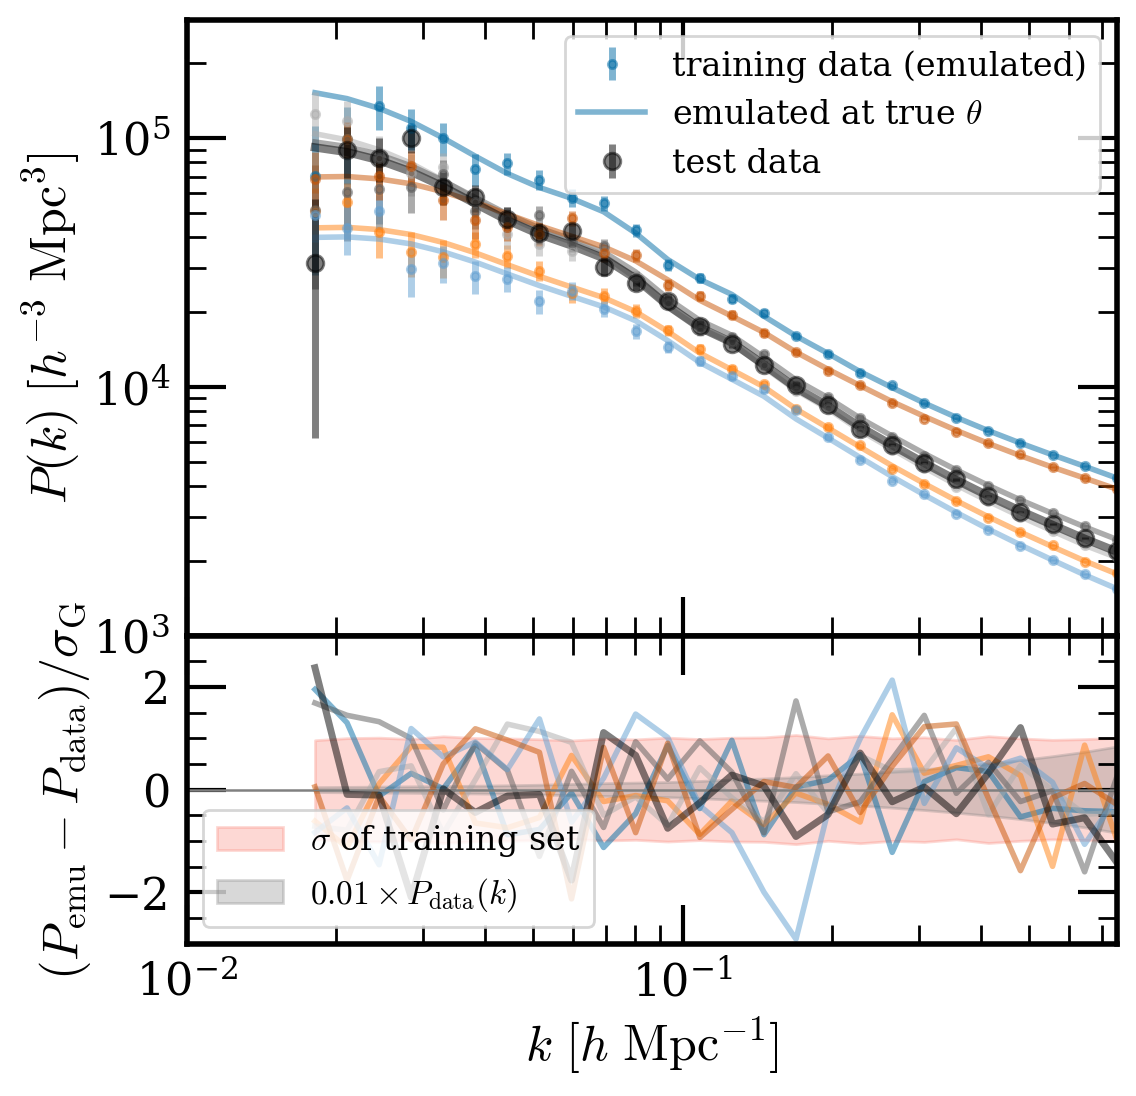

In [33]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)
    
    
# a few examples
#colors = ['red', 'orange', 'green', 'blue', 'purple']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lw = 2
show_error_all = True
for i in range(6):
    # for pp in range(len(param_names)):
    #     cosmo_params[emu_param_names[pp]] = theta[i][pp]
    # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                     **cosmo_params)
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless_train[i]
    
    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'training data (emulated)'
        label_emu = r'emulated at true $\theta$'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0 or show_error_all:
        axarr[0].errorbar(k, Pk_train[i], yerr=gaussian_error_pk_train[i], 
                          ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
    
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

    axarr[1].plot(k, (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
    axarr[1].axhline(0, color='grey', lw=0.5)
    
   

#axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='cyan', alpha=0.3,
#                      label='16-84 percentile of training set')
axarr[1].fill_between(k, -delta_pk_per_err_std, delta_pk_per_err_std, color='salmon', alpha=0.3,
                      label=r'$\sigma$ of training set')

# test data
color_test = 'k'
# for pp in range(len(param_names)):
#     cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
# _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
#                                                  **cosmo_params)
# in this case the orig emu pks are what we want
pk_model_unscaled = Pk_noiseless_test[idx_test]
axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, color=color_test, lw=3)
axarr[0].errorbar(k, Pk_test[idx_test], yerr=gaussian_error_pk_test[idx_test], 
                  ls='None', marker='o', markersize=6, alpha=0.5, label=f'test data', color=color_test)
axarr[1].plot(k, (pk_model_unscaled-Pk_test[idx_test])/gaussian_error_pk_test[idx_test], ls='-', alpha=0.5, color=color_test)

 # 1p emu error
err_1p = 0.01*pk_model_unscaled
label_err1p = r'$0.01 \times P_\text{data}(k)$'
axarr[1].fill_between(k, -err_1p/gaussian_error_pk_train[i], 
                          err_1p/gaussian_error_pk_train[i], color='grey', alpha=0.3,
                            label=label_err1p)

# plot settings
plt.xscale('log')
axarr[0].set_yscale('log')
    
plt.xlim(1e-2, 0.75)
axarr[0].set_ylim(1e3, 3e5)
axarr[1].set_ylim(-3, 3)
    
handles, labels = axarr[0].get_legend_handles_labels()
order = [1,0,2]
axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
# axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

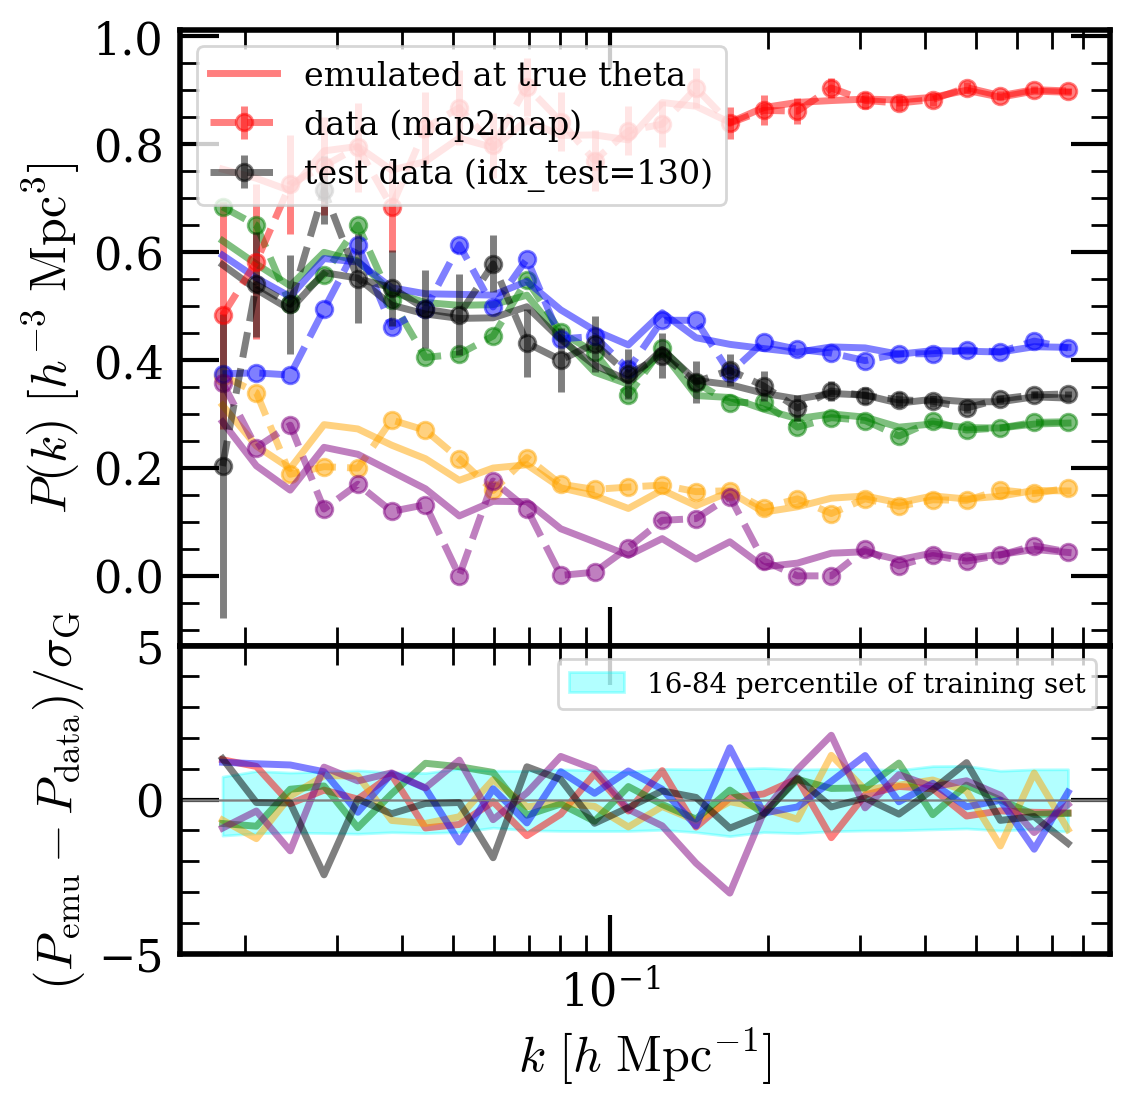

In [34]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

colors = ['red', 'orange', 'green', 'blue', 'purple']

for i in range(5):
    # for pp in range(len(param_names)):
    #     cosmo_params[emu_param_names[pp]] = theta[i][pp]
    # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                     **cosmo_params)
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless_train[i]
    pk_model_scaled = scaler.scale(pk_model_unscaled)
    
    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train_scaled[i], yerr=gaussian_error_pk_train_scaled[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train_scaled[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_scaled-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)    

axarr[1].fill_between(k, deltas_pk_per_err_scaled_16, deltas_pk_per_err_scaled_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

# test data
color_test = 'k'
# for pp in range(len(param_names)):
#     cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
# _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
#                                                  **cosmo_params)
pk_model_unscaled = Pk_noiseless_test[idx_test]
pk_model_scaled = scaler.scale(pk_model_unscaled)

axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, color=color_test)
axarr[0].errorbar(k, Pk_test_scaled[idx_test], yerr=gaussian_error_pk_test_scaled[idx_test], 
                  ls='--', marker='o', markersize=6, alpha=0.5, label=f'test data (idx_test={idx_test})', color=color_test)
axarr[1].plot(k, (pk_model_scaled-Pk_test_scaled[idx_test])/gaussian_error_pk_test_scaled[idx_test], ls='-', alpha=0.5, color=color_test)

# plot settings

plt.xscale('log')
#axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


### Set up and train Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [35]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU, Input

class neural_net():
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, 
                 hidden_size=32, learning_rate=None,
                 activation='leakyrelu',
                 alpha=0.1):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        self.hidden_size = hidden_size
        if activation=='leakyrelu':
            self.activation_func = LeakyReLU
            self.activation_kwargs = {'alpha': alpha}
        elif activation=='relu':
            self.activation_func = ReLU
            self.activation_kwargs = {}
        else:
            raise ValueError(f"Activation function {activation} not recognized")

        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(self.hidden_size, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = self.activation_func(**self.activation_kwargs)(x1)
        x2 = Dense(self.hidden_size, kernel_initializer='normal')(x1)
        x2 = self.activation_func(**self.activation_kwargs)(x2)
        x3 = Dense(self.hidden_size, kernel_initializer='normal')(x2)
        x3 = self.activation_func(**self.activation_kwargs)(x3)
        #x4 = Dense(self.output_size, kernel_initializer='normal', activation='relu')(x3)        
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

In [36]:
if run_moment:
    model_instance = neural_net(n_dim, n_params, 
                                hidden_size=64,
                                learning_rate=1e-3) 
    regression = model_instance.model() 

26
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 64)                1728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0  

Train initial model (basic MLP), as usual, on labeled data

In [37]:
np.min(Pk_train_scaled), np.min(Pk_val_scaled), np.min(theta_train), np.min(theta_val)

(0.0, -0.011693467976931219, 0.23024293, 0.23116569)

In [38]:
if run_moment:
    callback = tf.keras.callbacks.EarlyStopping(patience=25,
                                restore_best_weights=True,
                                start_from_epoch=200)
    history = regression.fit(Pk_train_scaled, theta_train,
                            epochs=2500, batch_size=64, shuffle=True,
                            callbacks=[callback],
                            validation_data=(Pk_val_scaled, theta_val))

Epoch 1/2500
13/13 [==============================] - 3s 97ms/step - loss: 0.3189 - val_loss: 0.2460
Epoch 2/2500
13/13 [==============================] - 1s 111ms/step - loss: 0.1369 - val_loss: 0.0453
Epoch 3/2500
13/13 [==============================] - 2s 135ms/step - loss: 0.0359 - val_loss: 0.0219
Epoch 4/2500
13/13 [==============================] - 1s 96ms/step - loss: 0.0241 - val_loss: 0.0166
Epoch 5/2500
13/13 [==============================] - 2s 130ms/step - loss: 0.0163 - val_loss: 0.0135
Epoch 6/2500
13/13 [==============================] - 1s 88ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 7/2500
13/13 [==============================] - 2s 112ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 8/2500
13/13 [==============================] - 2s 148ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 9/2500
13/13 [==============================] - 1s 93ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 10/2500
13/13 [==============================] - 1s 56ms/step - loss: 0.0076 - v

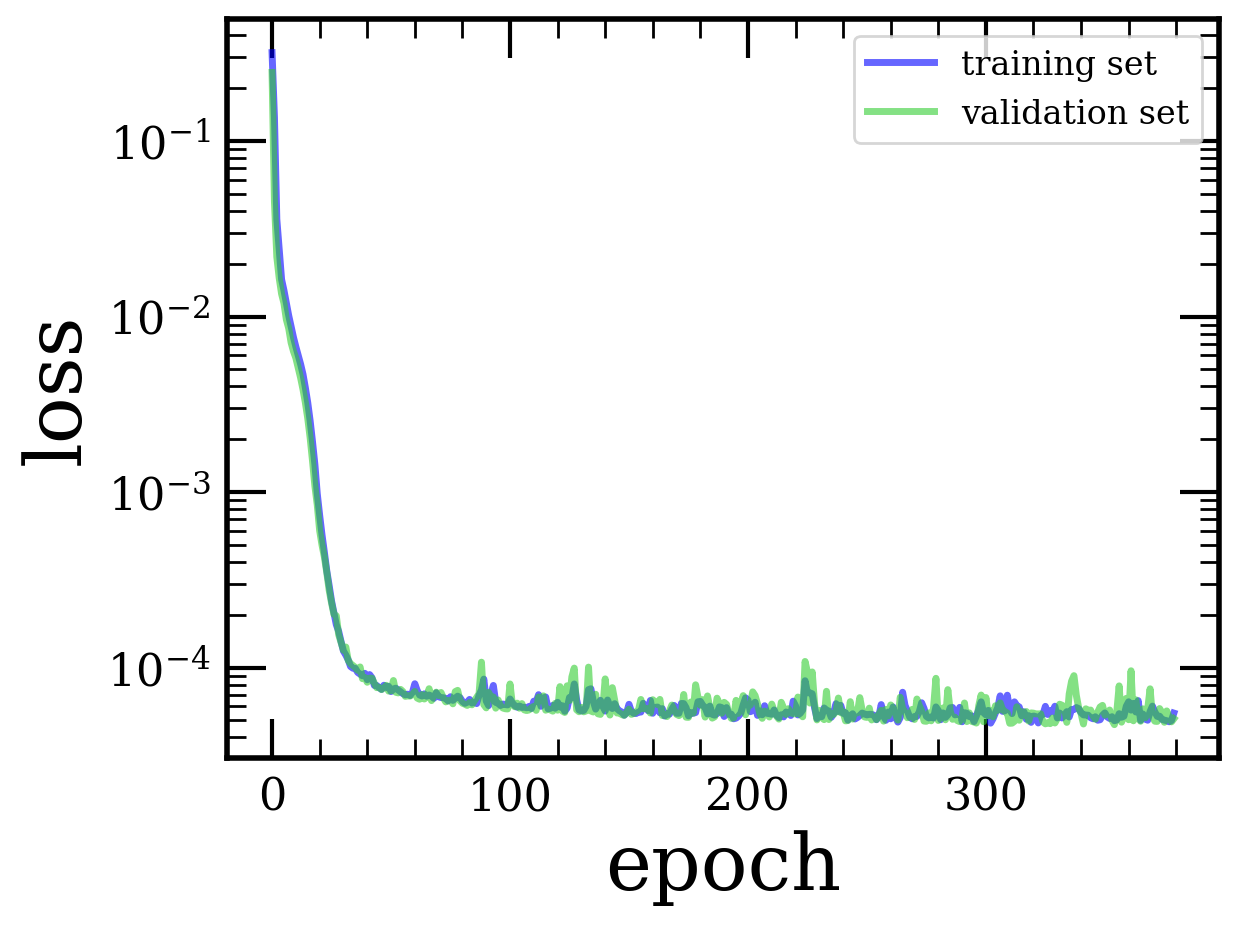

In [39]:
if run_moment:
    plt.plot(history.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

In [40]:
if run_moment:
    theta_train_pred = regression.predict(np.atleast_2d(Pk_train_scaled))
    theta_val_pred = regression.predict(np.atleast_2d(Pk_val_scaled))
    theta_test_pred = regression.predict(np.atleast_2d(Pk_test_scaled))

32/32 [==============================] - 1s 24ms/step


In [41]:
np.sum(np.isnan(theta_train_pred))

0

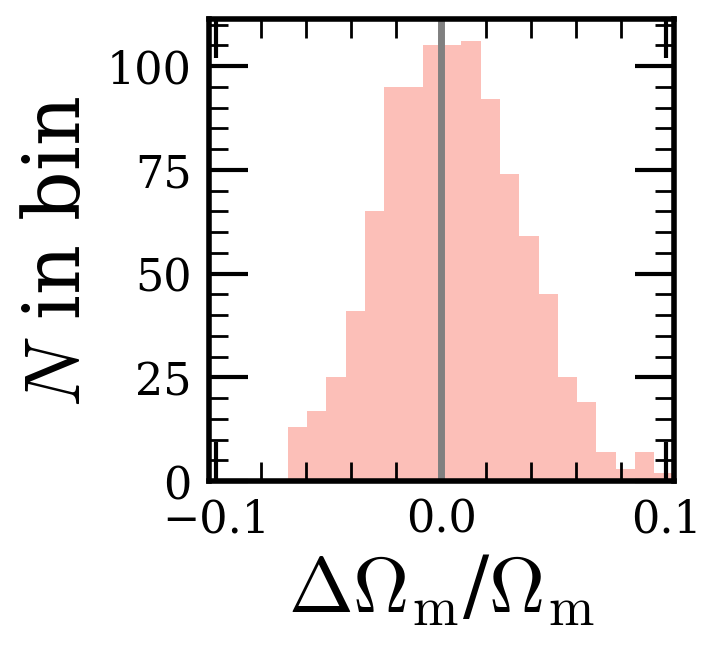

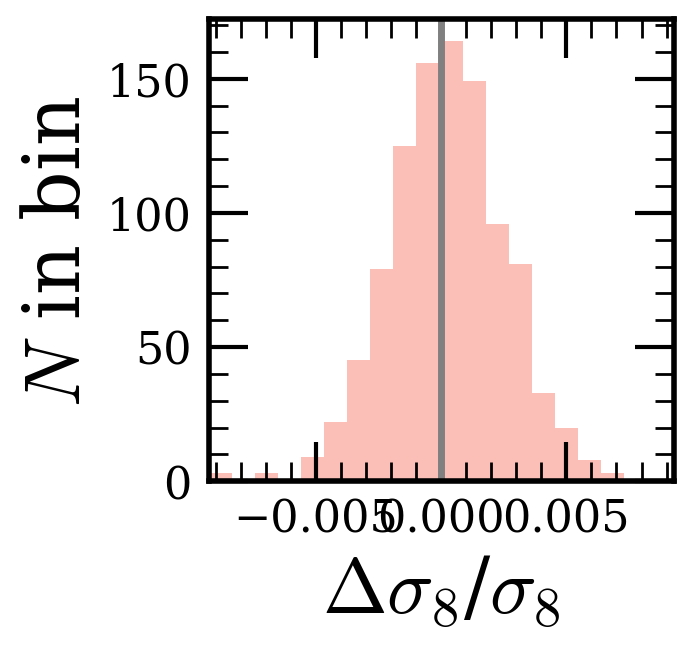

In [42]:
if run_moment:
    for pp in range(n_params):
        plt.figure(figsize=(3,3))
        #delta_param = (theta_train_pred[:,pp] - theta_train[:,pp])/theta_train[:,pp]
        delta_param = (theta_test_pred[:,pp] - theta_test[:,pp])/theta_test[:,pp]
        plt.hist(delta_param, bins=20, alpha=0.5, color='salmon')
        plt.xlabel(rf'$\Delta${param_labels[pp]}/{param_labels[pp]}')
        plt.ylabel(r'$N$ in bin')
        plt.axvline(0, color='grey')
        plt.xlim(-np.max(abs(delta_param)), np.max(abs(delta_param)))

In [43]:
theta_test_pred.shape

(1000, 2)

In [44]:
print(np.sum((theta_test_pred - theta_test)/theta_test, axis=1).shape)
idxs_test_ordered = np.argsort(np.sum(np.abs((theta_test_pred - theta_test)/theta_test), axis=1))
print(np.where(idxs_test_ordered==idx_test)[0])
idx_test_good = idxs_test_ordered[199]
print(idx_test, theta_test[idx_test], theta_test_pred[idx_test])
print(idx_test_good, theta_test[idx_test_good], theta_test_pred[idx_test_good])

(1000,)
[191]
130 [0.28700242 0.72403798] [0.28473526 0.7229767 ]
424 [0.39184448 0.86107982] [0.39538497 0.8618597 ]


Get means and residuals

In [45]:
include_covariances = True

In [46]:
if run_moment:
    cov_dict = {}

    covariances_train = []
    covariances_val = []
    covariances_test = []
    count = 0
    for i in range(n_params):
        for j in range(n_params):
            if not include_covariances:
                if i!=j:
                    continue
                
            if j<i:
                cov_dict[(i,j)] = cov_dict[(j,i)]
                continue
                
            covariances_train.append((theta_train[:,i]-theta_train_pred[:,i])* \
                            (theta_train[:,j]-theta_train_pred[:,j]))
                        
            covariances_val.append((theta_val[:,i]-theta_val_pred[:,i])* \
                                (theta_val[:,j]-theta_val_pred[:,j]))
            
            covariances_test.append((theta_test[:,i]-theta_test_pred[:,i])* \
                                 (theta_test[:,j]-theta_test_pred[:,j]))
            
            cov_dict[(i,j)] = count
            count += 1
            
    covariances_train = np.array(covariances_train).T
    covariances_val = np.array(covariances_val).T
    covariances_test = np.array(covariances_test).T

    n_covs = covariances_train.shape[1]

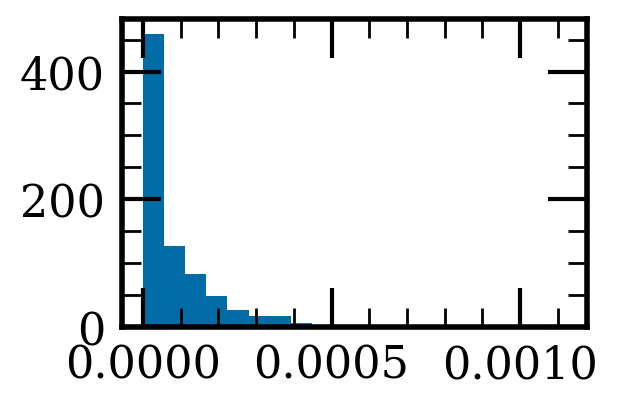

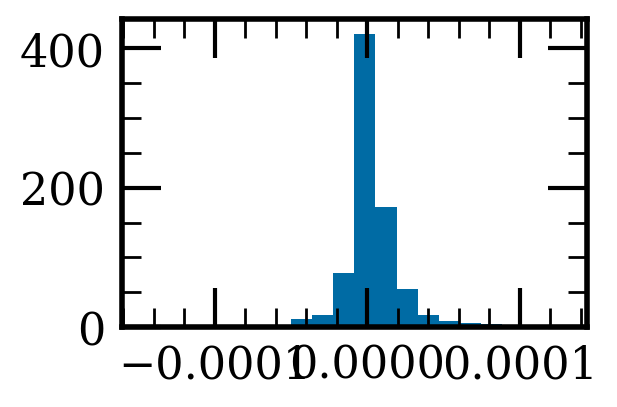

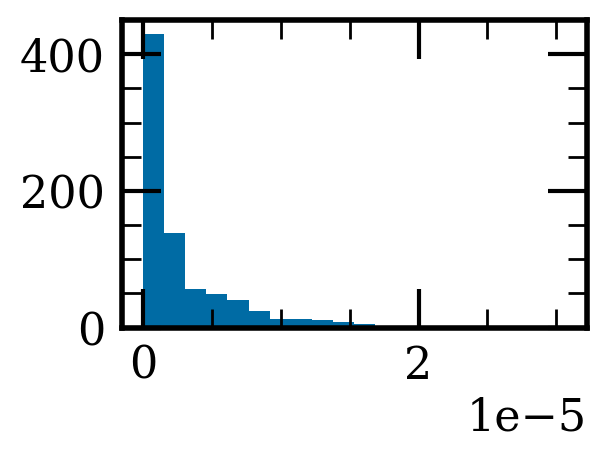

In [47]:
for pp in range(n_covs):
    plt.figure(figsize=(3,2))
    plt.hist(covariances_train[:,pp], bins=20)

In [48]:
scaler_cov = Scaler(func='minmax')
scaler_cov.fit(covariances_train)
covariances_train_scaled = scaler_cov.scale(covariances_train)
covariances_val_scaled = scaler_cov.scale(covariances_val)
covariances_test_scaled = scaler_cov.scale(covariances_test)

In [49]:
print(np.min(covariances_train, axis=0), np.max(covariances_train, axis=0))
print(np.min(covariances_train_scaled, axis=0), np.max(covariances_train_scaled, axis=0))

[ 1.77054259e-12 -1.47013670e-04  3.32558054e-13] [1.12081979e-03 1.30104591e-04 3.06756337e-05]
[0. 0. 0.] [1. 1. 1.]


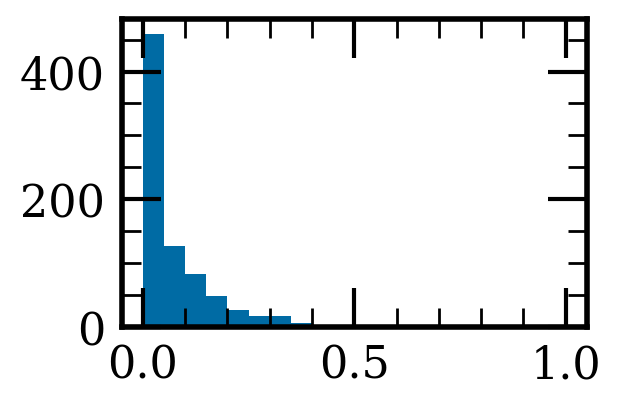

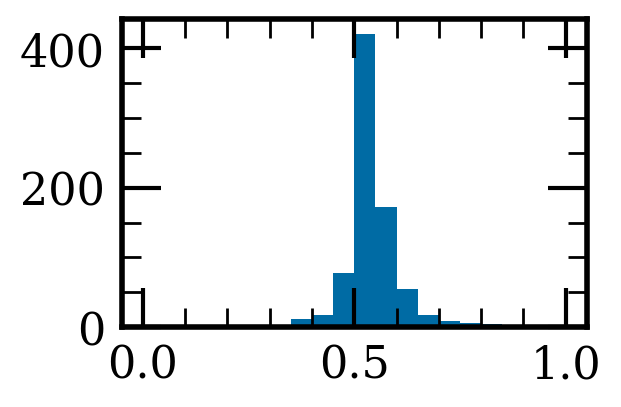

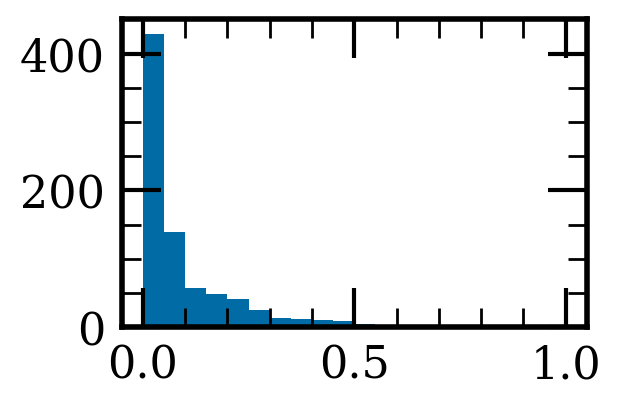

In [50]:
for pp in range(n_covs):
    plt.figure(figsize=(3,2))
    plt.hist(covariances_train_scaled[:,pp], bins=20)

In [51]:
if not include_covariances:
    assert np.all(covariances_train>=0)==True, "Should all be positive!"

In [52]:
def compute_cov_predmean(theta, theta_pred):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    n_samples = theta.shape[0]
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_pred[i][pp_i])*(theta[i][pp_j] - theta_pred[i][pp_j])
            cov[pp_i,pp_j] = val/n_samples
    return cov

def compute_cov_truemean(theta, bias=False):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    theta_means = np.mean(theta, axis=0)
    n_samples = theta.shape[0]
    if bias:
        norm = n_samples
    else:
        norm = n_samples - 1
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_means[pp_i])*(theta[i][pp_j] - theta_means[pp_j])
            cov[pp_i,pp_j] = val/norm
    return cov

In [53]:
if run_moment:
    model_instance = neural_net(n_dim, n_covs, 
                                hidden_size=64,
                                learning_rate=1e-2,
                                activation='leakyrelu',
                                alpha=0.1)
    regression_var_unknown_mean = model_instance.model()

26
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                1728      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0

In [54]:
if run_moment:
    
    callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                restore_best_weights=True,
                                start_from_epoch=100)
    
    history_var = regression_var_unknown_mean.fit(Pk_train_scaled,
                                            covariances_train_scaled,
                                            epochs=500, batch_size=64, shuffle=True,
                                            callbacks=[callback],
                                            validation_data = (Pk_val_scaled,
                                                                covariances_val_scaled))

Epoch 1/500
13/13 [==============================] - 2s 125ms/step - loss: 0.0984 - val_loss: 0.0686
Epoch 2/500
13/13 [==============================] - 2s 132ms/step - loss: 0.0360 - val_loss: 0.0317
Epoch 3/500
13/13 [==============================] - 2s 120ms/step - loss: 0.0223 - val_loss: 0.0230
Epoch 4/500
13/13 [==============================] - 2s 118ms/step - loss: 0.0186 - val_loss: 0.0203
Epoch 5/500


KeyboardInterrupt: 

In [ ]:
if run_moment:
    plt.plot(history_var.history['loss'], color='blue', label='training set', alpha=0.6)
    plt.plot(history_var.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    #plt.ylim(0, 0.005)

In [ ]:
predicted_var_obs_test_scaled = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
predicted_var_obs_test = scaler_cov.unscale(predicted_var_obs_test_scaled)
predicted_var_obs_test

### SBI

In [ ]:
if run_sbi:
    # TODO deal with validation fraction being taken from training set
    inference, posterior = sbi_tools.train_model(
        theta_train,
        Pk_train_scaled,
        prior=sbi_tools.get_prior(dict_bounds),
        training_batch_size=32,
        learning_rate=1e-3,
        validation_fraction=0.2
    )

### Explicit likelihood setup

In [ ]:
# for emcee
def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

# for dynesty
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [ ]:
global pk_data, cov_inv

def log_likelihood(theta):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    # print(theta)
    # print(cosmo_params)
    # print(pk_data)
    # print(pk_model)
    # print(cov_inv[0,0], cov_inv[1,1], cov_inv[2,2])
    # print(-0.5*np.dot(diff,np.dot(cov_inv,diff)))
    
    # print()
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

### Test on a model from the test set (held-out data)

Moment network:

In [ ]:
if run_moment:

    predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
    print(predicted_mean_obs_test)

    predicted_var_obs_test_scaled = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
    predicted_var_obs_test = scaler_cov.unscale(predicted_var_obs_test_scaled)

    moment_network_param_cov_test = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            if not include_covariances:
                if i!=j:
                    continue
            moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
    print(moment_network_param_cov_test)

    moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                        moment_network_param_cov_test,int(1e6)),dtype=np.float32)
    gc.collect()

SBI

In [ ]:
if run_sbi:
    samples_sbi_test = sbi_tools.sample_posteriors_theta_test(
        posterior,
        np.atleast_2d(pk_data),
        dict_bounds,
        N_samples=10000
    )[0]

MCMC, Dynesty:

In [ ]:
if run_dynesty:
    with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
        sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                            nlive=20, bound='single')
        sampler_test.run_nested(dlogz=0.01)
        
    results_test = sampler_test.results
    samples_dynesty_test = results_test.samples_equal()
    print(samples_dynesty_test.shape)

MCMC, emcee:

In [ ]:
if run_emcee:
    
    n_burn = 100
    n_steps = 500 # 50000
    n_walkers = 4 * n_params

    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

### Plot contours

Is there a "true" covariance in this toy case i can compare to?!?

In [ ]:
def plot_contours(extents={}, plot_moment=True, plot_sbi=True, plot_emcee=True, plot_dynesty=True):

    c = chainconsumer.ChainConsumer()

    if run_moment and plot_moment:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
                    name='Moment Network', color='blue')
                    )

    if run_sbi and plot_sbi:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_sbi_test, columns=param_names),
                    name='SBI', color='orange',
                    smooth=1, bins=10)
                    )

    if run_emcee and plot_emcee:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_emcee, columns=param_names),
                    name='MCMC (emcee)', color='purple', ls='--',
                    smooth=2, bins=10)
                    )

    if run_dynesty and plot_dynesty:
        c.add_chain(chainconsumer.Chain(
                    samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
                    name='MCMC (Dynesty)', color='green', 
                    smooth=2, bins=5)
                    )

    c.set_plot_config(
        chainconsumer.PlotConfig(
            flip=True,
            labels=param_label_dict,
            contour_label_font_size=12,
            extents=extents,
        )
    )

    truth_loc = dict(zip(param_names, theta_test[idx_test]))
    c.add_truth(chainconsumer.Truth(location=truth_loc))

    fig = c.plotter.plot(figsize = (5,4) )
    if save_plots:
        plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_emuPk}{tag_fit}.png')

In [ ]:
plot_contours()

In [ ]:
plot_contours(plot_moment=False)

In [ ]:
plot_contours(plot_emcee=False)

In [ ]:
plot_contours(extents=dict_bounds)

### For all test data

In [ ]:
sigmas_from_truth = []
sigmas_total = []

theta_test_pred = regression.predict(Pk_test_scaled)
vars_test_pred_scaled = regression_var_unknown_mean.predict(Pk_test_scaled)
vars_test_pred = scaler_cov.unscale(vars_test_pred_scaled)
#print(theta_pred_test.shape, vars_pred_test.shape)

for i in range(Pk_test_scaled.shape[0]):
    pk_data_test = Pk_test_scaled[i]
    
    moment_network_param_cov_test = np.zeros((n_params, n_params))
    for ii in range(n_params):
        for jj in range(n_params):
            if not include_covariances:
                if ii!=jj:
                    continue
            moment_network_param_cov_test[ii,jj] = vars_test_pred[i][cov_dict[(ii,jj)]]

    err = np.sqrt(np.diag(moment_network_param_cov_test))
    sigma_from_truth = (theta_test_pred[i] - theta_test[i])/err
    sigmas_from_truth.append(sigma_from_truth)
    
    diff = theta_test_pred[i] - theta_test[i]
    cov_pred_inv = np.linalg.inv(moment_network_param_cov_test)
    sigma_total = diff.T @ cov_pred_inv @ diff
    sigmas_total.append(sigma_total)

sigmas_from_truth = np.array(sigmas_from_truth)
sigmas_total = np.array(sigmas_total)



In [ ]:
print(np.sum((theta_test_pred - theta_test)/theta_test, axis=1).shape)
idxs_test_orderedchi2 = np.argsort(sigmas_total)
print(np.where(idxs_test_orderedchi2==idx_test)[0])
idx_test_goodchi2 = idxs_test_orderedchi2[201]
print(idx_test, sigmas_total[idx_test], theta_test[idx_test], theta_test_pred[idx_test])
print(idx_test_goodchi2, sigmas_total[idx_test_goodchi2], theta_test[idx_test_goodchi2], theta_test_pred[idx_test_goodchi2])

In [ ]:
# idx_nan = (vars_test_pred[:,0] < 0) | (vars_test_pred[:,2] < 0)
# print(np.sum(idx_nan))

In [ ]:
x_normal = np.linspace(-3, 3, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
#xmin, xmax = -np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]), np.max(abs(sigmas_from_truth[:,pp])[~idx_nan])
xmin, xmax = -3, 3
for pp in range(n_params):
    plt.figure(figsize=(3,3))
    plt.title(rf'{param_labels[pp]}')
    plt.hist(sigmas_from_truth[:,pp], bins=np.linspace(xmin, xmax, 20),
             color='salmon', alpha=0.5, density=True)
    plt.xlabel(r'$\sigma_\text{MN}$')
    plt.ylabel(r'$N$ in bin')

    plt.axvline(0, color='grey')
    
    plt.xlim(xmin, xmax)
    plt.plot(x_normal, y_normal, color='black', lw=1, label=r'$\mathcal{N}(0,1)$')
    plt.legend(fontsize=12)

In [ ]:
from scipy.stats import chi2

x_normal = np.linspace(0, 10, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
#xmin, xmax = -np.max(abs(sigmas_from_truth[:,pp])[~idx_nan]), np.max(abs(sigmas_from_truth[:,pp])[~idx_nan])
xmin, xmax = 0, 8

plt.figure(figsize=(3,3))
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$N$ in bin')
plt.hist(sigmas_total, bins=np.linspace(xmin, xmax, 20), color='salmon', alpha=0.5, density=True)
df = 2
plt.plot(x_normal, chi2.pdf(x_normal, df), color='black', lw=1, label=rf'$\chi^2$ PDF, df={df}')

plt.xlim(xmin, xmax)
plt.legend(fontsize=12)
#plt.plot(x_normal, y_normal, color='black', lw=1)

### Try another test model

In [ ]:
# idx_test = 8
# pk_data = Pk_test_scaled[idx_test]

Moment network:

In [ ]:
# if run_moment:
#     predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
#     predicted_var_obs_test_scaled = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
#     predicted_var_obs_test = scaler_cov.unscale(predicted_var_obs_test_scaled)

#     moment_network_param_cov_test = np.zeros((n_params, n_params))

#     for i in range(n_params):
#         for j in range(n_params):
#             if not include_covariances:
#                 if i!=j:
#                     continue
#             moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
#     print(moment_network_param_cov_test)
    
#     moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
#                                   moment_network_param_cov_test,int(1e6)),dtype=np.float32)
# gc.collect()

MCMC, Dynesty:

In [ ]:
# if run_dynesty:
#     with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
#         sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
#                                             nlive=20, bound='single')
#         sampler_test.run_nested(dlogz=0.01)
        
#     results_test = sampler_test.results
#     samples_dynesty_test = results_test.samples_equal()
#     print(samples_dynesty_test.shape)

MCMC, emcee:

In [ ]:
# if run_emcee:
#     rng = np.random.default_rng(seed=42)
#     theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
#                         for param_name in param_names] for _ in range(n_walkers)])

#     start = time.time()
#     if n_threads>1:
#         with Pool(processes=n_threads) as pool:
#             sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
#             _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
#     else:
#         sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
#         _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
#     end = time.time()

#     print(f"Time: {end-start} s ({(end-start)/60} min)")

#     samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
#     gc.collect()

In [ ]:
# plot_contours()